# Processamento e visualização de letras de música

In [14]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os, sys
import nltk
# stopwords em inglês
from nltk.corpus import stopwords

# insert dir of python scripts in the path
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
module_path

from src.utils import *
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lucas.carneiro\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
module_path

'c:\\Users\\lucas.carneiro\\visualizando_belchior'

In [5]:
artist = 'belchior'
artist = artist + '.csv'
filepath = os.path.join(module_path, 'raw_data', artist)
df = pd.read_csv(filepath)
df.head()

,título,mais tocada,letra,compositor
0,A Palo Seco,False,Se você vier me perguntar por onde andei No te...,Belchior
1,Aguapé,False,Capineiro de meu pai Não me cortes meus cabelo...,Belchior / CASTRO ALVES / Raimundo Fagner Epig...
2,Alucinação,False,Eu não estou interessado em nenhuma teoria Em ...,Belchior
3,Amor e Crime,False,"Amor, não há amor Existem só provas de amor Ma...",Belchior / francisco Casaverde
4,Apenas Um Rapaz Latino Americano,False,Eu sou apenas um rapaz latino-americano Sem di...,Belchior


# Pré-processamento

In [60]:
import string
from sklearn.feature_extraction.text import CountVectorizer

# stopwords inglês
stopwords_list = stopwords.words('english')
# stopwords pt-br
stopwords_path = os.path.join(module_path, 'linguistic_resources', 'stopwords.txt')
with open(stopwords_path) as f:
       for line in f:
            line = line.replace(' ','')
            line = line.replace('\n','')
            stopwords_list.append(line)

def preprocess(text):
    """
    Retorna um dado texto normalizado: caixa baixa, removendo pontuação, removendo stopwords
    """
    # caixa baixa
    text = text.lower()
    # remover pontuação
    punctuation = string.punctuation
    for punct in punctuation:
        text = text.replace(punct, ' ')
    # remove espaços em excesso
    text = re.sub(' +', ' ', text)

    # remove stopwords
    tokens = [t for t in text.split() if t not in stopwords_list and len(t) > 2]
    text = ' '.join(tokens)

    return text

def get_top_n_ngrams(corpus, ngram = (1,1), n=None):
    """
    Para uma dada lista de strings, calcula os n-gramas mais frequentes
    """
    if type(corpus) == str:
        corpus = [corpus]
    vec = CountVectorizer(ngram_range = ngram).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

def build_ngram_df(corpus, ngram = (1,1), n=None,):
    """
    Cria um dataframe de n-gramas
    """
    ngrams = get_top_n_ngrams(corpus, ngram, n)
    df1 = pd.DataFrame(ngrams, columns = ['ngrams' , 'count'])
    df1 = df1.groupby('ngrams').sum()['count'].sort_values(ascending=False)
    return df1

def plot_ngrams(ngrams, col = 'C0', orientation = 'vertical'):
    """
    Gráfico de barras dos n-gramas mais frequentes
    """
    labels = list(ngrams.index)
    values = list(ngrams.values)
    #
    if orientation == 'vertical':
        g = sns.barplot(y=labels, x=values, color = col)
        for p in g.patches:
            g.annotate(format(p.get_width(), '.0f'), (p.get_width(), 
                                                       p.get_y() + p.get_height()/2.), ha = 'center', 
                       va = 'center', xytext = (10, 0), textcoords = 'offset points')
    else:
        plt.xticks(values, labels, rotation='vertical')
        g = sns.barplot(x=labels, y=values, color = col) 
        for p in g.patches:
            g.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., 
                                                       p.get_height()), ha = 'center', 
                       va = 'center', xytext = (0, 5), textcoords = 'offset points') 
    

In [61]:
df['letra normalizada'] = [preprocess(text) for text in df['letra']]

In [62]:
# tamanho dos textos
df['número de palavras'] = [len(string.split()) for string in df['letra']]
df['número de caracteres'] = [len(string) for string in df['letra']]

In [92]:
aguape = list(df[df['título']=='Aguapé']['letra normalizada'])[0]
for t in aguape.split():
    if 'tra' in t:
        print(t)

estrada
atrapalham
estrada
estrada


In [90]:

tokens = (lyrics).split()
for t in tokens:
    if 'tra' == t:
        print(t)

tra
tra
tra
tra
tra
tra


In [68]:
# termos que aparecem em mais músicas
song_dict = dict(zip(df['título'], df['letra normalizada']))
tokens = set(' '.join(df['letra normalizada']).split())
number_of_songs_by_token = {}
songs_by_token = {}
for token in tokens:
    for song in song_dict.keys():
        if token in song_dict[song]:
            n = number_of_songs_by_token.get(token, 0)
            n += 1
            number_of_songs_by_token[token] = n

            songs = songs_by_token.get(token, '')
            songs = songs.split()
            songs.append(song)
            songs_by_token[token] = ' '.join(songs)

In [69]:
df_songs_tokens = pd.concat([pd.Series(number_of_songs_by_token), pd.Series(songs_by_token)], axis = 1)
df_songs_tokens.columns = ['número de músicas em que o termo ocorre', 'músicas em que o termo ocorre']
df_songs_tokens = df_songs_tokens.sort_values(by = 'número de músicas em que o termo ocorre', ascending = False)
df_songs_tokens.head(10)

,número de músicas em que o termo ocorre,músicas em que o termo ocorre
não,70,Aguapé Alucinação Amor e Crime Apenas Um Rapaz...
est,61,A Palo Seco Aguapé Alucinação Amor e Crime Art...
tra,61,Aguapé Alucinação Apenas Um Rapaz Latino Ameri...
ora,58,Aguapé Amor e Crime Arte Final Bahiuno Baihuno...
ente,54,A Palo Seco Aguapé Alucinação Apenas Um Rapaz ...
cor,54,A Palo Seco Aguapé Alucinação Apenas Um Rapaz ...
con,52,A Palo Seco Aguapé Apenas Um Rapaz Latino Amer...
ver,52,Alucinação Apenas Um Rapaz Latino Americano At...
des,51,A Palo Seco Alucinação Amor e Crime Arte Final...
ida,51,Alucinação Amor e Crime Apenas Um Rapaz Latino...


In [75]:
a = list(df[df['título']=='Aguapé']['letra normalizada'])[0]
for b in a.split():
    if 'tra' in b:
        print(b)

estrada
atrapalham
estrada
estrada


# Visualizações estáticas

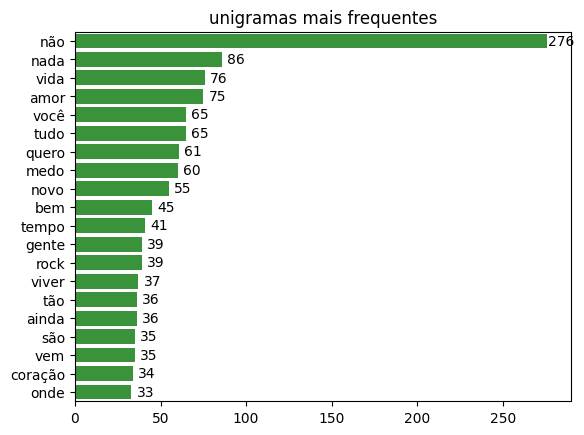

In [63]:
# unigramas
lyrics = ' '.join(list(df['letra normalizada']))
n_grams = (1,1)
total_bigrams = build_ngram_df(lyrics, ngram = n_grams, n=20)
plt.title('unigramas mais frequentes')
plot_ngrams(total_bigrams, col='C2', orientation = 'vertical')

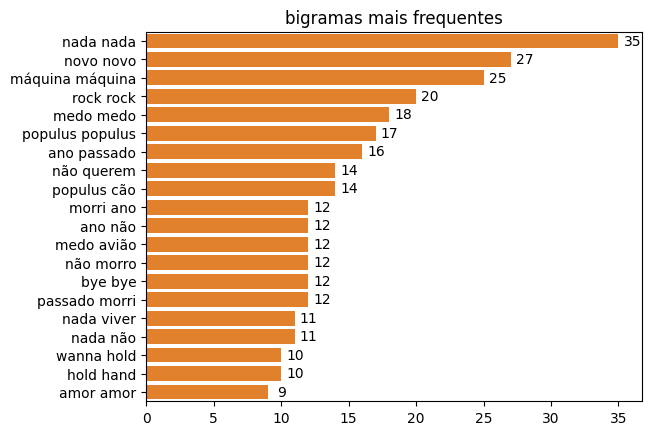

In [64]:
n_grams = (2,2)
total_bigrams = build_ngram_df(lyrics, ngram = n_grams, n=20)
plt.title('bigramas mais frequentes')
plot_ngrams(total_bigrams, col='C1', orientation = 'vertical')